<a href="https://colab.research.google.com/github/amalvarezme/ProcesoDigitalSen/blob/master/PDS_Notebooks/Representacion_TF_Wavelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representaciones tiempo frecuencia (escala) - Wavelets

In [ ]:
import sympy #Acualización: 12 de Julio 2020 - Finalizado
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.gridspec as gridspec
import scipy.fft as ft
import ipywidgets 
from sympy import lambdify, pprint, diff, fourier_transform, integrate, oo
from ipywidgets import interactive
from mpl_toolkits.mplot3d import Axes3D

class Wavelet_trasform():

  def __init__(self, sig, t_dis, Ts, int_sca, Te, frec):
    self.Ts = Ts
    self.sca_lim = int_sca
    self.Te = Te
    self.frec = frec
    self.fc = np.sqrt(5/2)/(2*np.pi)
    self.t_dis = t_dis
    self.sig = sig
    self.scales = np.arange(self.sca_lim[0], self.sca_lim[1], self.Te)
    self.coefs = self.direct(self.sig, self.scales, self.Ts)
    self.freqs = self.fc * self.scales ** -1

  def grap(self):
    self.fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8,8))
    axs[0].plot(self.t_dis, self.sig)
    axs[0].grid()
    axs[0].arrow(0, axs[0].axis()[2], 0, -axs[0].axis()[2]+axs[0].axis()[3], width=.005, length_includes_head=True, color='k')
    axs[0].arrow(axs[0].axis()[0], 0, -axs[0].axis()[0]+axs[0].axis()[1], 0, width=.005, length_includes_head=True, color='k')
    axs[0].set_ymargin(0)
    axs[0].set_ylabel('Señal', fontsize=20)
    if self.frec == True:
      axs[1].pcolormesh(self.t_dis, self.freqs, self.coefs)
      axs[1].set_ylabel('Frecuencia $(Hz)$', fontsize=20)
    else:
      axs[1].pcolormesh(self.t_dis, self.scales, self.coefs)
      axs[1].set_ylabel('Escala $a$', fontsize=20)
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Tiempo $(seg)$', fontsize=20)
    return self.fig.show()

  def direct(self, sig, scales, Ts):
    output = np.zeros((len(self.scales), len(self.sig)))
    for ind, width in enumerate(self.scales/self.Ts):
        N = np.min([10 * width, len(self.sig)])
        wavelet_data = np.conj(self.mexh(N, width)[::-1])
        output[ind,:] = np.convolve(self.sig, wavelet_data, mode='same')
    return output

  def mexh(self, points, a):
    A = 2 / (np.sqrt(3 * a) * (np.pi**0.25))
    wsq = a**2
    vec = np.arange(0, points) - (points - 1.0) / 2
    xsq = vec**2
    mod = (1 - xsq / wsq)
    gauss = np.exp(-xsq / (2 * wsq))
    total = A * mod * gauss
    return total

  def inverse(self, a_max, a_min, b_max, b_min):
    a_sup = np.where(self.scales >= a_max-2*self.Te )[0][0]
    a_inf = np.where(self.scales <= a_min)[0][-1]
    b_sup = np.where(self.t_dis >= b_max-2*self.Ts )[0][0]
    b_inf = np.where(self.t_dis <= b_min)[0][-1]
    scales_a = self.scales[a_inf:a_sup]
    coefs_a = self.coefs[a_inf:a_sup, b_inf:b_sup]
    x_n = np.sum(coefs_a.real.T / (scales_a/self.Ts ** .5), axis=-1).T * ((self.Te)/((2 / (np.sqrt(3) * (np.pi**0.25)))))
    fig, axs = plt.subplots(2, figsize=(15,12), gridspec_kw={'hspace': 0.15})
    axs[0].plot(self.t_dis, self.sig, label = 'Señal original', ls = ':')
    axs[0].plot(self.t_dis[b_inf:b_sup], x_n, label = 'Señal reconstruida')
    axs[0].legend(loc = 'best')
    axs[0].grid()
    axs[0].arrow(0, axs[0].axis()[2], 0, -axs[0].axis()[2]+axs[0].axis()[3], width=.005, length_includes_head=True, color='k')
    axs[0].arrow(axs[0].axis()[0], 0, -axs[0].axis()[0]+axs[0].axis()[1], 0, width=.005, length_includes_head=True, color='k')
    axs[0].set_ymargin(0)
    axs[0].set_ylabel('Señal', fontsize=20)
    axs[0].set_xlabel('Tiempo $(seg)$', fontsize=20)
    axs[1].pcolormesh(self.t_dis, self.scales, self.coefs)
    axs[1].set_ylabel('Escala $a$', fontsize=20)
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Localización $b$', fontsize=20)
    axs[1].add_patch(pat.Rectangle((b_min, a_min), b_max-b_min, a_max-a_min, fill = False, linewidth = 1))
    return fig.show()

# **La Transformada Wavelet**


## Introducción

La transformada Wavelet es una transformación lineal que actúa sobre una función compleja de variable real que permite resaltar características en el tiempo y frecuencia (escala) de la misma, mediante la proyección sobre versiones dilatadas y trasladadas de otra función llamada Wavelet madre.

## Función Wavelet madre

Una función Wavelet madre $\psi (t)$ es aquella función compleja de variable real que cumple las siguientes condiciones:

1. Energía finita.

$$
\int_{-\infty}^{\infty} |\psi(t)|^2~dt < \infty
$$

Lo que quiere decir que la función Wavelet tiene su energía localizada en el tiempo, además $\psi (t) \in L^{2}(\mathbb{R})$.

2. Valor medio cero.

$$
\int_{-\infty}^{\infty} \psi(t)~dt = 0
$$

Sea $\Psi (f)$ la transformada de Fourier de la función Wavelet $\psi (t)$. La condición anterior puede ser expresada mediante su representación espectral de la siguiente manera:

$$
\Psi (0)  = 0
$$

La condición anterior garantiza que la transformada Wavelet representa a una determinada función sin perder información (esto se explicará más adelante). Además, se da origen a la siguiente ecuación.

$$
C_{g} = \int_{0}^{\infty} \frac{|\Psi (f)|^{2}}{f} ~df < \infty
$$

Donde $C_{g}$ se conoce como _constante de admisibilidad_.

3. Si la función Wavelet madre es compleja, su transformada de Fourier debe desvanecerse rápidamente para frecuencias negativas.

## Wavelet sombrero mexicano (Mexican Hat)

Considere una función Gaussiana de la siguiente forma:

$$
x(t)=e^{-\frac{t^2}{2}}
$$

y sus primeras derivadas como se muestra gráficamente a continuación.

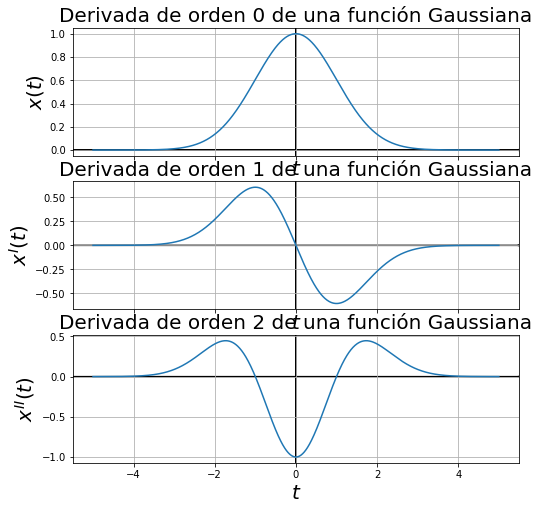

In [ ]:
t = sympy.symbols('t')
gauss = sympy.exp(-(t**2/2))
t_dis = np.linspace(-5, 5, 1000)
fig, axs = plt.subplots(3, sharex=True, figsize=(8,8))
for i in range(3):
    gauss_dis = lambdify(t, diff(gauss, t, i), 'numpy')
    axs[i].plot(t_dis, gauss_dis(t_dis))
    axs[i].set_title('Derivada de orden {} de una función Gaussiana'.format(i), fontsize=20)
    axs[i].arrow(0, axs[i].axis()[2], 0, -axs[i].axis()[2]+axs[i].axis()[3], width=.005, length_includes_head=True, color='k')
    axs[i].arrow(axs[i].axis()[0], 0, -axs[i].axis()[0]+axs[i].axis()[1], 0, width=.005, length_includes_head=True, color='k')
    axs[i].grid()
    if i==0: axs[i].set_ylabel('$x(t)$', fontsize=20)
    elif i==1: axs[i].set_ylabel('$x^{I}(t)$', fontsize=20)
    elif i==2: axs[i].set_ylabel('$x^{II}(t)$', fontsize=20)
    axs[i].set_xlabel('$t$', fontsize=20)
    fig.show()


  La función Wavelet Mexican Hat se define como la segunda derivada negativa de una función Gaussiana.

$$
\psi (t) = -\frac{d^{2}}{dt^{2}}x(t) = (1-t^{2})~e^{-\frac{t^{2}}{2}}
$$

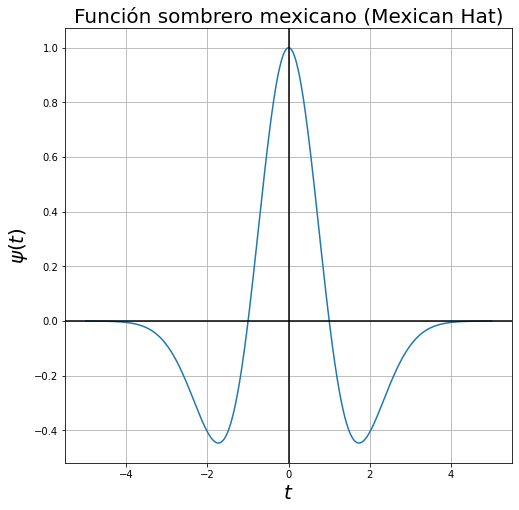

In [ ]:
psi = -diff(gauss, t, 2)
psi_dis = lambdify(t, psi, 'numpy')
plt.figure(figsize=(8, 8))
plt.plot(t_dis, psi_dis(t_dis))
plt.title('Función sombrero mexicano (Mexican Hat)', fontsize=20)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$\psi (t)$', fontsize=20)
plt.grid()
plt.show()

A continuación se verifican las condiciones que debe cumplir una función Wavelet sobre la función Mexican Hat.

1. Energia finita.

In [ ]:
pprint(integrate(psi**2, (t, -oo, oo)))

3⋅√π
────
 4  


2. Valor medio cero.

In [ ]:
pprint(integrate(psi, (t, -oo, oo)))

0


Y su respectiva constante de admisibilidad $C_g$.

In [ ]:
f = sympy.symbols('f')
psif = fourier_transform(psi, t, f)
pprint(integrate((psif**2)/f, (f, 0, oo)))

π


La siguiente figura muestra la transformada de Fourier $\Psi (f)$ de la función Mexican Hat.

$$
\Psi (f) = \int_{-\infty}^{\infty} \psi(t)~e^{-j2 \pi f t}~dt\\
= \int_{-\infty}^{\infty} (1-t^{2})~e^{-\frac{t^{2}}{2}}~e^{-j2 \pi f t}~dt\\
= 4\sqrt{2} \pi^{\frac{5}{2}}f^{2}~e^{-2\pi^{2}f^{2}}
$$

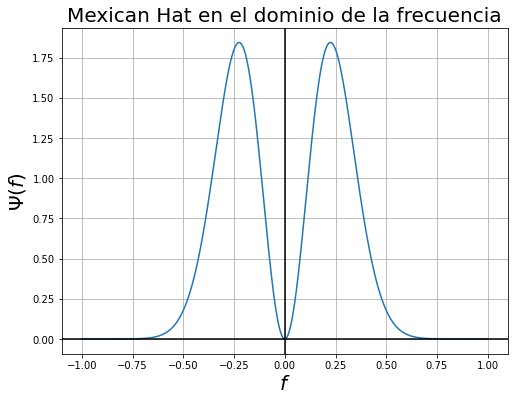

In [ ]:
f_dis = np.linspace(-1, 1, 1000)
psif_dis = lambdify(f, psif, 'numpy')
plt.figure(figsize=(8, 6))
plt.plot(f_dis, psif_dis(f_dis))
plt.title('Mexican Hat en el dominio de la frecuencia', fontsize=20)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('$f$', fontsize=20)
plt.ylabel('$\Psi(f)$', fontsize=20)
plt.grid()
plt.show()

Note que debido a que la función Mexican Hat es real, su transformada de Fourier resulta ser una función con simetría par. De igual manera, al ser simétrica la función Mexican Hat, su espectro en frecuencia es real. Con base en los resultados anteriores, la función Mexican Hat resulta ser un filtro pasabandas.

Además, se cumple el teorema de Parseval.

$$
\int_{-\infty}^{\infty} |\psi(t)|^2~dt = \int_{-\infty}^{\infty} |\Psi(f)|^2~df
$$

In [ ]:
integrate(psi**2, (t, -oo, oo)) == integrate(psif**2, (f, -oo, oo))

True

## Transformada Wavelet

Una vez escogida la función Wavelet madre, es posible emplear dos tipos de transformaciones a su variable independiente real; dilatación y traslación.

### Dilatación

Sea el parámetro $a \in \mathbb{R^{+}}$. El conjunto de todas las versiones dilatadas de la Wavelet madre puede escribirse como sigue:

$$
\psi (t|a) = \left(1-\left(\frac{t}{a}\right) ^{2}\right) ~e^{-\frac{1}{2} \left(\frac{t}{a}\right) ^{2}}
$$

De esta manera, el parámetro $a$ es proporcional al ensanchamiento que sufre la función Wavelet madre. De hecho, para la función Mexican Hat, este parámetro resulta ser la distancia que existe entre el valor máximo de la función y su corte con el eje de las abscisas.

A continuación se muestran diferentes dilataciones de la Wavelet Mexican Hat.


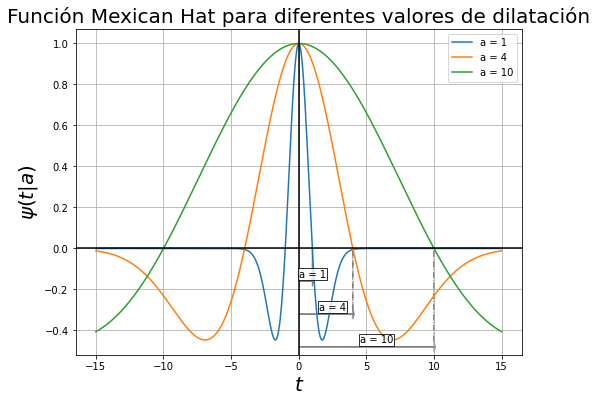

In [ ]:
a, b = sympy.symbols('a, b')
psi_ab = (1-((t-b)/a)**2)*sympy.exp(-(((t-b)/a)**2)/2)
plt.figure(figsize=(8, 6))
t_dis = np.linspace(-15, 15, 1000)
for i, j in zip([1, 4, 10], [1, 2, 3]):
    psi_ab_dis = lambdify(t, psi_ab.subs([(a, i), (b, 0)]), 'numpy')
    plt.plot(t_dis, psi_ab_dis(t_dis), label='a = {}'.format(i))
    plt.arrow(x=0, y=-.16*j, dx=i, dy=0, color='gray', head_width=.05, head_length=.1, shape='full')
    plt.arrow(x=i, y=0, dx=0, dy=-.15*j, color='gray', ls='-.')
    plt.annotate('a = {}'.format(i), (.5*i-.5, -.16*j+.02), bbox={'facecolor':'white', 'alpha':.8, 'pad':1})
plt.title('Función Mexican Hat para diferentes valores de dilatación', fontsize=20)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$ \psi (t|a) $', fontsize=20)
plt.legend(loc='best')
plt.grid()
plt.show()

Gráficamente se puede apreciar que a medida que aumenta el valor del parámetro $a$, aumenta el área bajo la curva de la señal Wavelet y por lo tanto su energía. Es posible determinar analiticamente como el parametro $a$ afecta la energia de la señal.

Sea $\varepsilon_{\psi}$ la energia de la Wavelet madre.

$$
\varepsilon_{\psi} = \int_{-\infty}^{\infty} |\psi(t)|^2~dt
$$

La energía de la versión Wavelet dilatada un factor $a$ es la siguiente:

$$
\int_{-\infty}^{\infty} \left| \psi\left(\frac{t}{a}\right)\right|~^2~dt = a~\int_{-\infty}^{\infty} |\psi(u)|^2~du = a~\varepsilon_{\psi}
$$

Por lo tanto, si la Wavelet madre se dilata $a$ veces, su energía aumentará en el mismo factor. Para que la Wavelet conserve la misma cantidad de energía sin importar que tanto se dilate, es necesario establecer una función de peso $w(a)$ que acompañe a la función original. La insistencia en que las versiones dilatadas de la Wavelet madre conserven la misma cantidad de energía se verá más adelante.

A continuación se determina el valor de la función $w(a)$.

$$
\int_{-\infty}^{\infty} \big|~w(a)~\psi\left(\frac{t}{a}\right)\big|~^2~dt = \varepsilon_{\psi}\\
|w(a)|^{2}~\int_{-\infty}^{\infty} \left| \psi\left(\frac{t}{a}\right)\right|~^2~dt = \varepsilon_{\psi}\\
 |w(a)|^{2}~a~\varepsilon_{\psi} = \varepsilon_{\psi}
$$

$$
w(a) = \frac{1}{\sqrt{a}}
$$

Finalmente, el conjunto de versiones dilatadas de la Wavelet madre de tal forma que todas conservan la energía de su versión no dilatada (o dilatación $a = 1$) para la función Mexican Hat es el siguiente:

$$
\psi (t|a) = \frac{1}{\sqrt{a}}\left(1-\left(\frac{t}{a}\right) ^{2}\right) ~e^{-\frac{1}{2} \left(\frac{t}{a}\right) ^{2}}
$$

A continuación se muestra algunos ejemplos de versiones trasladadas de la función anterior.

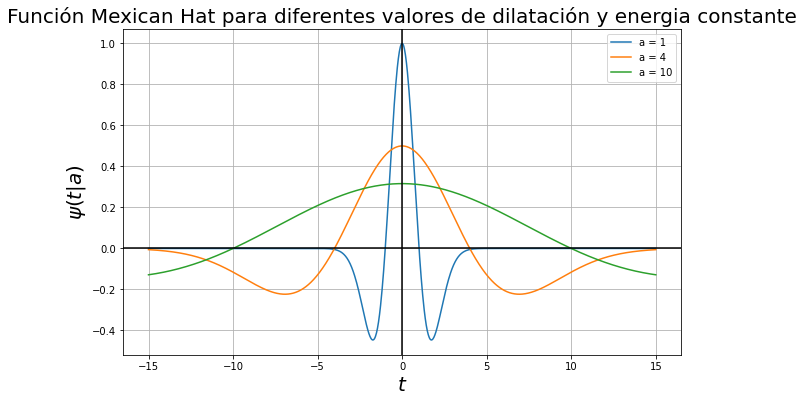

In [ ]:
psi_ab = (a**(-1/2))*(1-((t-b)/a)**2)*sympy.exp(-(((t-b)/a)**2)/2)
plt.figure(figsize=(10, 6))
for i in [1, 4, 10]:
    psi_ab_dis = lambdify(t, psi_ab.subs([(a, i), (b, 0)]), 'numpy')
    plt.plot(t_dis, psi_ab_dis(t_dis), label='a = {}'.format(i))
plt.title('Función Mexican Hat para diferentes valores de dilatación y energia constante', fontsize=20)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$ \psi (t|a) $', fontsize=20)
plt.legend(loc='best')
plt.grid()
plt.show()

El efecto de dilatar la función Wavelet en el tiempo se refleja en la contracción de su espectro en frecuencia.

$$
\int_{-\infty}^{\infty} \psi\left(\frac{t}{a}\right)~e^{-j2 \pi f t}~dt = a~\Psi(af)
$$

Por lo tanto, el parámetro $a$ permite controlar el ancho de banda de la Wavelet en frecuencia, siendo estos dos inversamente proporcionales. En la siguiente figura se muestra algunos ejemplos de espectros de la Mexican Hat para diferentes valores de $a$.

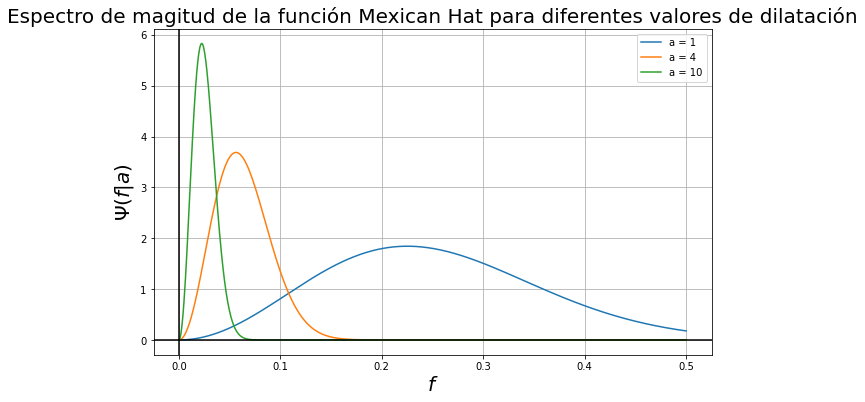

In [ ]:
f_dis = np.linspace(0, 0.5, 1000)
plt.figure(figsize=(10, 6))
for i in [1, 4, 10]:
    psif_ab = fourier_transform(psi_ab.subs([(b, 0), (a, i)]), t, f)
    psif_ab_dis = lambdify(f, psif_ab, 'numpy')
    plt.plot(f_dis, psif_ab_dis(f_dis), label='a = {}'.format(i))
plt.title('Espectro de magitud de la función Mexican Hat para diferentes valores de dilatación', fontsize=20)
plt.legend(loc='best')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('$f$', fontsize=20)
plt.ylabel('$ \Psi (f|a) $', fontsize=20)
plt.legend(loc='best')
plt.grid()
plt.show()

### Traslación

Sea el parámetro $b \in \mathbb{R}$. El conjunto de todas las versiones trasladadas de la Wavelet madre puede escribirse como sigue:

$$
\psi (t|b) = \left(1-(t-b)) ^{2}\right) ~e^{-\frac{1}{2} (t-b) ^{2}}
$$

De esta manera, el parámetro $b$ determina el punto en el tiempo en donde la Wavelet madre está centrada.
A continuación se muestran diferentes versiones trasladadas de la Wavelet Mexican Hat.

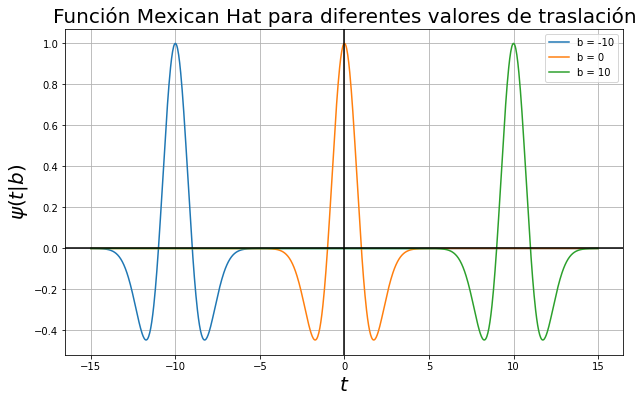

In [ ]:
plt.figure(figsize=(10, 6))
for i in [-10, 0, 10]:
    psi_ab_dis = lambdify(t, psi_ab.subs([(a, 1), (b, i)]), 'numpy')
    plt.plot(t_dis, psi_ab_dis(t_dis), label='b = {}'.format(i))
plt.title('Función Mexican Hat para diferentes valores de traslación', fontsize=20)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$ \psi (t|b) $', fontsize=20)
plt.legend(loc='best')
plt.grid()
plt.show()

El efecto de trasladar la función Wavelet madre en el tiempo se refleja en un desfase en su espectro de frecuencia.

$$
\int_{-\infty}^{\infty} \psi (t-b)~e^{-j2 \pi f t}~dt = e^{-j2 \pi f b}~\Psi(f)
$$

Note que su magnitud se mantiene constante. Sea $\Phi_{\Psi}(f)$ la función de fase del espectro de frecuencia de la función Wavelet. De forma analítica se puede determinar su relacion con el parametro $b$.

$$
\Phi_{\Psi}(f) = tan^{-1}\left( \frac{Im\{ e^{-j2 \pi f b}~\Psi(f) \}}{Re\{ e^{-j2 \pi f b}~\Psi(f) \}} \right) = -2 \pi fb
$$

Por lo tanto, el parámetro $b$ resulta ser proporcional a la pendiente del espectro de fase de la Wavelet en frecuencia.

In [ ]:
f_dis = np.linspace(0, 0.5, 1000)
def grap(B):
    plt.figure(figsize=(10, 6))
    f, t = sympy.symbols('f, t')
    psif_ab = fourier_transform(psi_ab.subs([(b, B), (a, 1)]), t, f)
    psif_ab_dis = lambdify(f, psif_ab, 'numpy')
    plt.plot(f_dis, np.angle(psif_ab_dis(f_dis)))
    plt.yticks(np.arange(-np.pi, 1.5*np.pi, np.pi*0.5), ('$-\pi$', '$-\pi/2$',
                                                     '$0$', '$\pi/2$', '$\pi$'), fontsize=20)
    plt.title('Espectro de fase de la función Mexican Hat para diferentes valores de desplazamiento',
              fontsize=20)
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.xlabel('$f$', fontsize=20)
    plt.ylabel('$\Phi_{\Psi}(f)$', fontsize=20)
    plt.grid()
    plt.show()
display(interactive(grap, B=ipywidgets.IntSlider(value=7, min=-20, max=20, step=1, description='Valor de b:', continuous_update=False)))

interactive(children=(IntSlider(value=7, continuous_update=False, description='Valor de b:', max=20, min=-20),…

Finalmente, el conjunto de todas las versiones dilatadas y trasladadas de la función Wavelet madre y que conservan la misma energía se denota de la siguiente manera:

$$
\psi_{a,b} (t) = \psi (t|a, b) = \frac{1}{\sqrt{a}}\psi \left(\frac{t-b}{a}\right)
$$

Para el caso de la función Mexican Hat:

$$
\psi_{a, b} (t) = \frac{1}{\sqrt{a}}\left(1-\left(\frac{t-b}{a}\right) ^{2}\right) ~e^{-\frac{1}{2} \left(\frac{t-b}{a}\right) ^{2}}
$$

La transformada Wavelet continua de una función $x(t)$ tal que $x:\mathbb{R} \rightarrow \mathbb{C}$ es:

$$
T(a, b) = \int_{-\infty}^{\infty} x(t)~ \psi^{*}_{a,b} (t)~dt
$$

donde $^{*}$ denota el conjugado de la función. La transformada Wavelet resulta ser la representación integral de la función $x(t)$ a partir de sus proyecciones sobre versiones dilatadas y trasladadas de la Wavelet madre $\psi(t)$. La expresión anterior se puede escribir de manera más compacta, y adquiere la forma del producto interno entre la señal $x(t)$ y $\psi_{a, b} (t)$.

$$
T(a, b) = \langle x(t), \psi_{a, b} (t) \rangle
$$


## Identificación de estructuras coherentes

A continuación se ilustra el proceso de cómo la transformada Wavelet actúa sobre una función. En la siguiente figura se muestra el efecto de la transformada Wavelet sobre una función cosenoidal utilizando como Wavelet madre la Mexican Hat para diferentes valores de localización $b$. De color azul se reslata las secciones de la Wavelet madre que hacen que $T(a, b)$ tengan un valor positivo, mientras para que resaltar los valores negativos se utiliza el color rojo. 

In [ ]:
x = sympy.cos(2*sympy.pi*t/4)
x_dis = lambdify(t, x, 'numpy')
def IEC_1(B):
    Fs = 5000
    Ts = Fs**-1
    t_dis = np.arange(-9, 9, Ts)
    plt.figure(figsize=(10, 6))
    f, t = sympy.symbols('f, t')
    psi_ab_dis = lambdify(t, psi_ab.subs([(a, 1), (b, B)]), 'numpy')
    plt.plot(t_dis, psi_ab_dis(t_dis))
    plt.fill_between(t_dis, psi_ab_dis(t_dis), 0,
                     where=psi_ab_dis(t_dis)*x_dis(t_dis) >= 0, facecolor='blue', alpha=.3)
    plt.fill_between(t_dis, psi_ab_dis(t_dis), 0,
                     where=psi_ab_dis(t_dis)*x_dis(t_dis) < 0, facecolor='red', alpha=.3)
    plt.plot(t_dis, x_dis(t_dis))
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('$ \psi_{1, b}(t),~cos(2~\pi ~0.25~t)$', fontsize=20)
    plt.annotate('$T(1, {}) = {}$'.format(B, np.around(Ts*np.dot(x_dis(t_dis), psi_ab_dis(t_dis)), 3
                    )), (-7.5, -0.75), bbox={'facecolor':'white', 'alpha':.8, 'pad':2.5})
    plt.grid()
    plt.show()
display(interactive(IEC_1, B=ipywidgets.IntSlider(value=0, min=-6, max=6, step=1, description='Valor de b:', continuous_update=False)))


interactive(children=(IntSlider(value=0, continuous_update=False, description='Valor de b:', max=6, min=-6), O…

La gráfica de $T(1, b)$ contra $b$ para el ejemplo anterior es la siguiente.

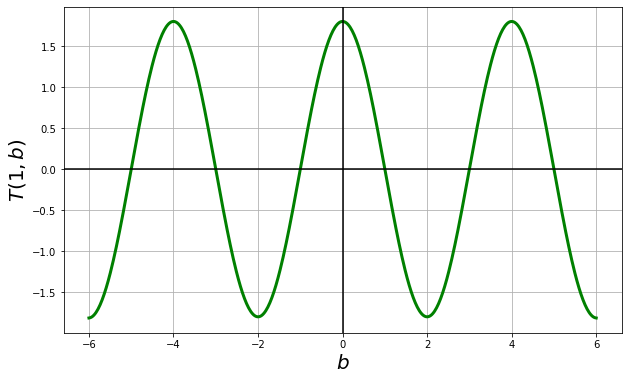

In [ ]:
T = []
Fs = 500
Ts = Fs**-1
t_dis = np.arange(-9, 9, Ts)
b_dis = np.linspace(-6, 6, 500)
plt.figure(figsize=(10, 6))
for i in b_dis:
    psi_ab_dis = lambdify(t, psi_ab.subs([(a, 1), (b, i)]), 'numpy')
    T.append(Ts*np.dot(x_dis(t_dis), psi_ab_dis(t_dis)))
plt.plot(b_dis, T, color='green', linewidth=3)
plt.xlabel('$b$', fontsize=20)
plt.ylabel('$T(1, b)$', fontsize=20)
plt.grid()
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()

Los resultados anteriores muestran que si la Wavelet se encuentra en fase con la función cosenoidal, su respectiva transformada tendrá un valor pico positivo, mientras que si se encuentra en contrafase, alcanzará un valor pico de igual magnitud pero negativo. Además, si la Wavelet se encuentra a un cuarto del periodo de la función cosenoidal, su transformada tendrá como valor cero. Note que la transformada Wavelet es capaz de identificar y resaltar estructuras en donde la proyección de la función sobre la Wavelet madre es alta.

En la siguiente figura se muestra el efecto de la transformada Wavelet sobre una función cosenoidal utilizando como Wavelet madre la Mexican Hat para diferentes valores de dilatación $a$. Nuevamente, de color azul se reslata las secciones de la Wavelet madre que hacen que $T(a, b)$ tengan un valor positivo, mientras para que resulatar los valores negativos se utiliza el color rojo. 

In [ ]:
def IEC_2(A):
    Fs = 5000
    Ts = Fs**-1
    t_dis = np.arange(-6, 6, Ts)
    fig = plt.figure(figsize=(10, 6))
    f = sympy.symbols('f')
    t = sympy.symbols('t')
    psi_ab_dis = lambdify(t, psi_ab.subs([(a, A), (b, 0)]), 'numpy')
    plt.plot(t_dis, psi_ab_dis(t_dis))
    plt.fill_between(t_dis, psi_ab_dis(t_dis), 0,
                     where=psi_ab_dis(t_dis)*x_dis(t_dis) >= 0, facecolor='blue', alpha=.3)
    plt.fill_between(t_dis, psi_ab_dis(t_dis), 0,
                     where=psi_ab_dis(t_dis)*x_dis(t_dis) < 0, facecolor='red', alpha=.3)
    plt.plot(t_dis, x_dis(t_dis))
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('$ \psi_{a, 0}(t),~cos(2~\pi ~0.25~t)$', fontsize=20)
    plt.annotate('$T({}, 0) = {}$'.format(A, np.around(Ts*np.dot(x_dis(t_dis), psi_ab_dis(t_dis)), 3
                    )), (-4, -0.75), bbox={'facecolor':'white', 'alpha':.8, 'pad':2.5})
    plt.grid()
    plt.show()
display(interactive(IEC_2, A=ipywidgets.FloatSlider(value=1, min=.05, max=50, step=.05, description='Valor de a:', continuous_update=False)))

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Valor de a:', max=50.0, min…

La gráfica de $T(a, 0)$ contra $a$ para el ejemplo anterior es la siguiente.

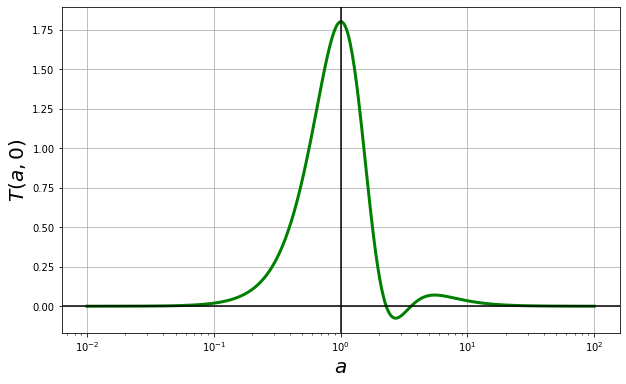

In [ ]:
T = []
Fs = 500
Ts = Fs**-1
t_dis = np.arange(-6, 6, Ts)
a_dis = np.logspace(-2, 2, 500)
plt.figure(figsize=(10, 6))
for i in a_dis:
    psi_ab_dis = lambdify(t, psi_ab.subs([(a, i), (b, 0)]), 'numpy')
    T.append(Ts*np.dot(x_dis(t_dis), psi_ab_dis(t_dis)))
plt.semilogx(a_dis, T, color='green', linewidth=3)
plt.xlabel('$a$', fontsize=20)
plt.ylabel('$T(a, 0)$', fontsize=20)
plt.grid()
plt.axhline(0, color='black')
plt.axvline(1, color='black')
plt.show()

Con base en lo anterior, tanto para valores muy altos o muy bajos de dilatación, la transformada Wavelet toma valores cercanos a cero. Solo existe un máximo y se da cuando la dilatación alcanza un cuarto del periodo de la señal cosenoidal. De nuevo se resaltan estructuras en donde la proyección entre la señal cosenoidal y la función Wavelet madre es alta.

Para ver en conjunto como la transformada Wavelet varía con respecto a los valores que toma $a$ y $b$ se construye la siguiente figura. Desde este punto en adelante la función Wavelet madre es normalizada con el fin de que su energía sea siempre la unidad. Para el caso de la Mexican Hat, basta con multiplicar a la función original por el factor $\frac{2}{\sqrt{3} \sqrt[4]{\pi}}$. 

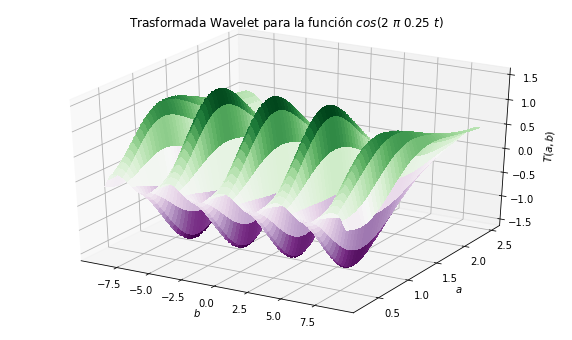

In [ ]:
Fs = 250
Ts = 1/Fs
t_dis = np.arange(-9, 9, Ts)
sig  = np.cos(2 * np.pi * .25 * t_dis)
coefs = Wavelet_trasform(sig, t_dis, Ts, (.25, 2.5), .01, True).coefs
scales = Wavelet_trasform(sig, t_dis, Ts, (.25, 2.5), .01, True).scales
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
X = t_dis
Y = scales
X, Y = np.meshgrid(X, Y)
Z = coefs/(np.sqrt(10)**np.log10(Fs))
ax.plot_surface(X, Y, Z, cmap='PRGn', linewidth=0, antialiased=False)
ax.set_xlabel('$b$')
ax.set_ylabel('$a$')
ax.set_zlabel('$T(a, b)$')
ax.set_title('Trasformada Wavelet para la función $cos(2~\pi ~0.25~t)$')
plt.show()

Ahora bien, resulta más sencillo y práctico visualizar los valores de $T(a, b)$  en un plano que contenga sus curvas de nivel, como se muestra en la siguiente figura. Además, como el valor de $b$ coincide con la localización en tiempo de la señal y el parámetro $a$ es inversamente proporcional a la frecuencia a la que esta oscila, se utilizan las unidades de _tiempo_ y _frecuencia_ en lugar de $b$ y $a$.

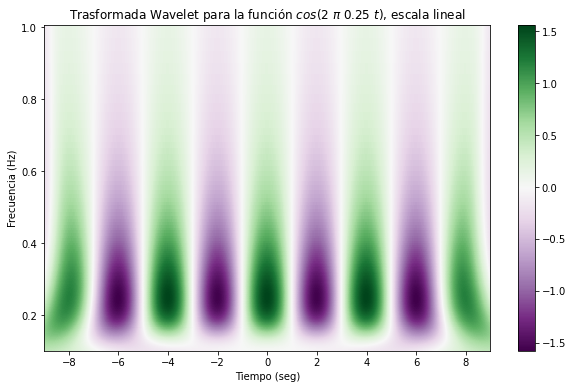

In [ ]:
plt.figure(figsize=(10, 6))
freqs = Wavelet_trasform(sig, t_dis, Ts, (.25, 2.5), .01, True).freqs
plt.pcolormesh(t_dis, freqs, coefs/(np.sqrt(10)**np.log10(Fs)), cmap='PRGn')
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (seg)')
plt.colorbar()
plt.title('Trasformada Wavelet para la función $cos(2~\pi ~0.25~t)$, escala lineal')
plt.show()

Para una mejor visualización de las componentes frecuenciales, se opta por una escala logarítmica.

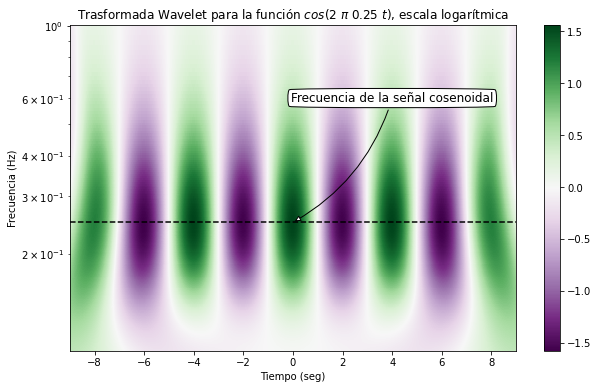

In [ ]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_dis, freqs, coefs/(np.sqrt(10)**np.log10(Fs)), cmap='PRGn')
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (seg)')
plt.yscale('log')
plt.colorbar()
plt.title('Trasformada Wavelet para la función $cos(2~\pi ~0.25~t)$, escala logarítmica')
plt.axhline(.25, color='black', ls='--')
plt.annotate('Frecuencia de la señal cosenoidal', xy=(0, .25), xytext=(4, 0.6), 
                  size=12, va="center", ha="center", bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", fc="w"))
plt.show()

Como era de esperar, la transformada Wavelet toma valores picos a la misma frecuencia de la señal cosenoidal analizada y lo hace de forma periódica en el tiempo.

Ahora se analiza el caso para dos señales cosenoidales superpuestas. Cabe mencionar de que si no se hubiese utilizado la función de peso $w(a)$ como se dijo anteriormente, las componentes de alta frecuencia se verán opacadas y resaltan más las componentes de baja frecuencia.

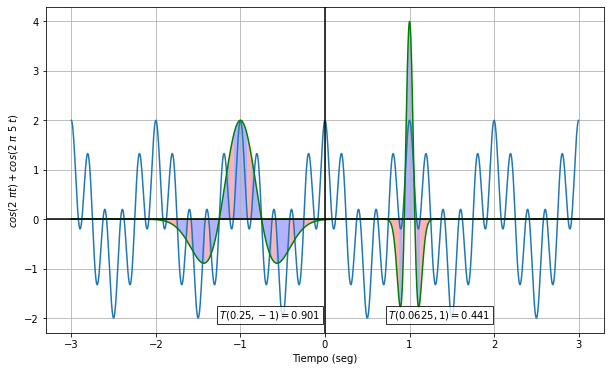

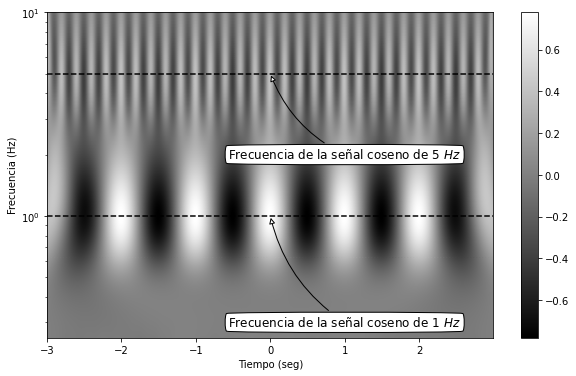

In [ ]:
Fs = 1000
Ts = 1/Fs
t_dis = np.arange(-3, 3, Ts)
sig  = np.cos(2 * np.pi * 1 * t_dis) + np.cos(2 * np.pi * 5 * t_dis)#0.025, 1, 0.001
coefs = Wavelet_trasform(sig, t_dis, Ts, (.025, 1), 1e-3, True).coefs
freqs = Wavelet_trasform(sig, t_dis, Ts, (.025, 1), 1e-3, True).freqs
plt.figure(figsize=(10, 6))
plt.plot(t_dis, sig)
for i, j in zip([.25, .25/4], [-1, 1]):
    psi_ab_dis = lambdify(t, psi_ab.subs([(a, i), (b, j)]), 'numpy')
    plt.plot(t_dis, psi_ab_dis(t_dis), color='green')
    plt.fill_between(t_dis, psi_ab_dis(t_dis), 0,
                     where=psi_ab_dis(t_dis)*sig >= 0, facecolor='blue', alpha=.3)
    plt.fill_between(t_dis, psi_ab_dis(t_dis), 0,
                     where=psi_ab_dis(t_dis)*sig < 0, facecolor='red', alpha=.3)
    plt.annotate('$T({}, {}) = {}$'.format(i, j, np.around(Ts*np.dot(sig, psi_ab_dis(t_dis)), 3
                    )), (j-.25, -2), bbox={'facecolor':'white', 'alpha':.8, 'pad':2.5})
plt.grid()
plt.ylabel('$cos(2~\pi t) + cos(2~\pi ~5~t)$')
plt.xlabel('Tiempo (seg)')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_dis, freqs, coefs/(np.sqrt(10)**np.log10(Fs)), cmap=plt.cm.gray)
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (seg)')
plt.yscale('log')
plt.axhline(5, color='black', ls='--')
plt.annotate('Frecuencia de la señal coseno de $5~Hz$', xy=(0, 5), xytext=(1, 2), 
                  size=12, va="center", ha="center", bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", fc="w"))
plt.axhline(1, color='black', ls='--')
plt.annotate('Frecuencia de la señal coseno de $1~Hz$', xy=(0, 1), xytext=(1, .3), 
                  size=12, va="center", ha="center", bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", fc="w"))
plt.colorbar()
plt.show()

En el siguiente ejemplo se presenta el caso de una señal cosenoidal con ruido localizado. Note que la transformada Wavelet además de descomponer la señal original en sus componentes frecuenciales, localiza la señal de ruido en el tiempo.

<Figure size 720x432 with 0 Axes>

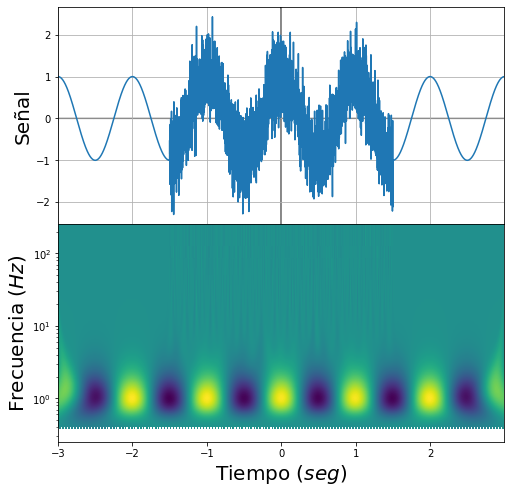

In [ ]:
Fs = 1000
Ts = 1/Fs
t_dis = np.arange(-3, 3, Ts)
e = np.zeros(t_dis.shape[0]) 
m = .5*np.random.randn(int(t_dis.shape[0]*0.75))
for i in range(int(t_dis.shape[0]*0.25), m.shape[0]):
    e[i] = m[i]
plt.figure(figsize=(10, 6))
sig  = np.cos(2 * np.pi * 1 * t_dis) + e
Wavelet_trasform(sig, t_dis, Ts, (1e-3, 1), 1e-3, True).grap()
plt.show()

A continuación se presentan otros ejemplos de señales variadas y su transformada Wavelet utilizando la función Mexican Hat.

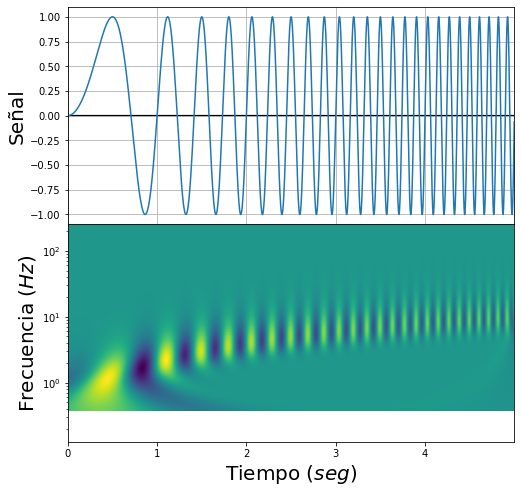

In [ ]:
Fs = 1000
Ts = 1/Fs
t_dis = np.arange(0, 5, Ts)
sig  = np.sin(2 * np.pi * 1 * t_dis**2)
Wavelet_trasform(sig, t_dis, Ts, (1e-3, 2), 1e-3, True).grap()

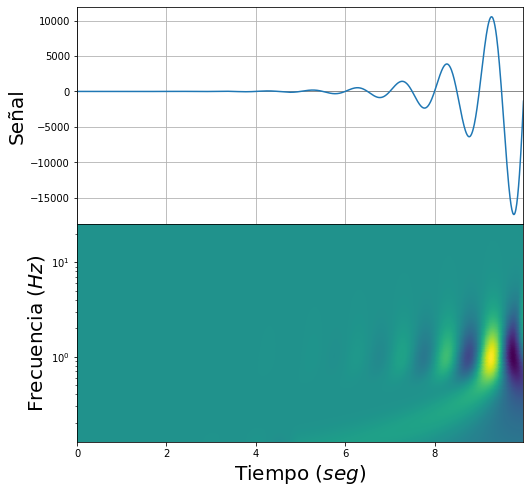

In [ ]:
Fs = 100
Ts = 1/Fs
t_dis = np.arange(0, 10, Ts)
sig  = np.exp(t_dis)*np.sin(2 * np.pi * 1 * t_dis)
Wavelet_trasform(sig, t_dis, Ts, (1e-2, 2), 1e-3, True).grap()

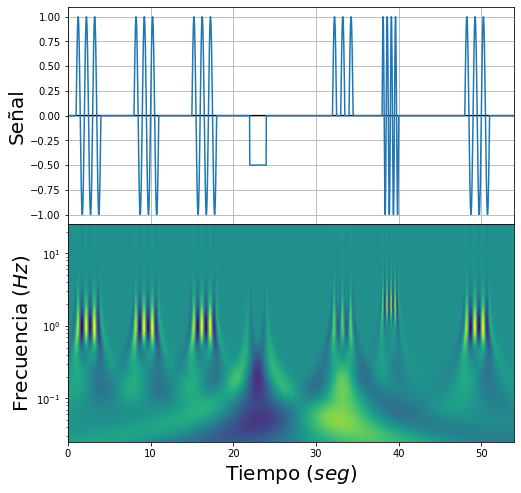

In [ ]:
Fs = 50
Ts = 1/Fs
t_dis = np.arange(0, 54, Ts)
sig = np.piecewise(t_dis,
                   [t_dis >= 1, t_dis>=4, t_dis>=8, t_dis>=11, t_dis>=15, t_dis>=18, t_dis>=22, t_dis>=24,
                    t_dis>=32, t_dis>=32.5, t_dis>=33, t_dis>=33.5, t_dis>=34, t_dis>=34.5, t_dis>=38, t_dis>=40,
                   t_dis>=48, t_dis>=51],
                   [lambda x: np.sin(2*np.pi*x), 0, lambda x: np.sin(2*np.pi*x), 0,lambda x: np.sin(2*np.pi*x), 0,
                    -0.5, 0, lambda x: np.sin(2*np.pi*x), 0, lambda x: np.sin(2*np.pi*x), 0,
                   lambda x: np.sin(2*np.pi*x), 0, lambda x: np.sin(4*np.pi*x), 0, lambda x: np.sin(2*np.pi*x), 0])
Wavelet_trasform(sig, t_dis, Ts, (1e-2, 10), 1e-2, True).grap()

## Detección de discontinuidades

La transformada Wavelet es útil para detectar discontinuidades en la señal a analizar. Note en las siguientes figuras que las discontinuidades se destacan como fronteras entre un valor pico alto y otro bajo que a medida que aumenta la frecuencia converge a un punto. Además, los cambios bruscos también se perciben de forma parecida.

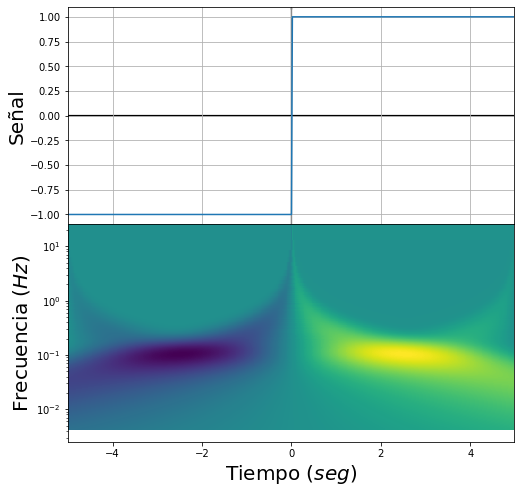

In [ ]:
Fs = 50
Ts = 1/Fs
t_dis = np.arange(-5, 5, Ts)
sig = np.piecewise(t_dis, [t_dis <0, t_dis>=0], [-1, 1])
Wavelet_trasform(sig, t_dis, Ts, (1e-2, 100), 1e-2, True).grap()

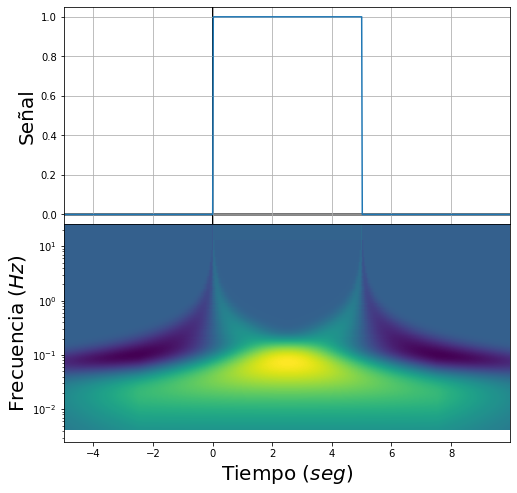

In [ ]:
Fs = 50
Ts = 1/Fs
t_dis = np.arange(-5, 10, Ts)
sig = np.piecewise(t_dis, [t_dis>=0, t_dis>=5], [1, 0])
Wavelet_trasform(sig, t_dis, Ts, (1e-2, 100), 1e-2, True).grap()

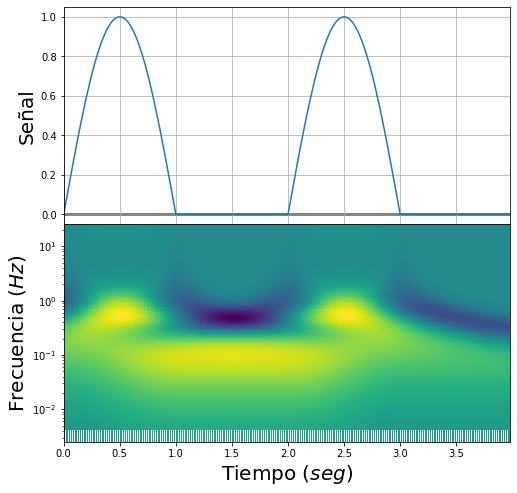

In [ ]:
Fs = 50
Ts = 1/Fs
t_dis = np.arange(0, 4, Ts)
sig = np.piecewise(t_dis, [t_dis>0, t_dis>1, t_dis>2, t_dis>3], [lambda x: np.sin(np.pi*x), 0,
                                                                 lambda x: np.sin(np.pi*x), 0])
Wavelet_trasform(sig, t_dis, Ts, (1e-2, 100), 1e-2, True).grap()

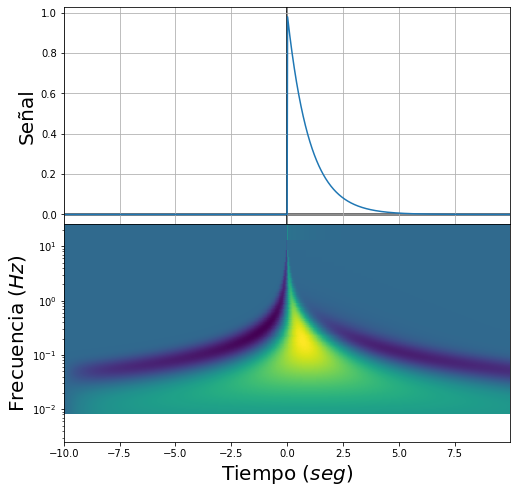

In [ ]:
Fs = 50
Ts = 1/Fs
t_dis = np.arange(-10, 10, Ts)
sig = np.piecewise(t_dis, [t_dis>=0], [lambda x: np.exp(-x)])
Wavelet_trasform(sig, t_dis, Ts, (1e-2, 100), 1e-2, True).grap()

Como se mencionó anteriormente, la existencia de la constante de admisibilidad $C_g< \infty$ garantiza el cumplimineto del teorema de Parseval y por lo tanto, que la transformada Wavelet no pierda información de la señal a analizar.

Si esto es cierto, debe cumplirse que la suma de la magnitud al cuadrado de cada elemento del dominio de la transformada Wavelet de la señal (es decir, la energía de la transformada Wavelet de la señal) debe ser igual a la energía de la señal en el domino del tiempo multiplicada por una constante de proporcionalidad. 

$$
\int_{0}^{\infty} \int_{-\infty}^{\infty} |T(a, b)|^{2}~db~da = \alpha~\int_{-\infty}^{\infty} |x(t)|^{2}~dt
$$

El objetivo es entonces, encontrar el valor de $\alpha$. Sea $\mathscr{F\{\cdot  \}}$ la notación para la trasformada de Fourier.

$$
\int_{-\infty}^{\infty} |T(a, b)|^{2}~db = \int_{-\infty}^{\infty} \mathscr{F} |\{ T(a, b) \}|^{2} ~df
$$

$$
\mathscr{F} \{ |T(a, b)| \} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} x(t)~\frac{1}{\sqrt{a}}\psi ^{*} \left(\frac{t-b}{a}\right)~dt~e^{-j~2 \pi f b}~db
$$

Realizando el cambio de variable $u = \frac{t-b}{a}$, $db=-a~du$.

$$
\mathscr{F} \{ |T(a, b)| \} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} x(t)~\sqrt{a}~\psi^{*} (u)~e^{-j~2\pi ft}~e^{j~2\pi fau}dt~du\\
= \int_{-\infty}^{\infty} x(t)~\sqrt{a} ~e^{-j~2\pi ft} \int_{-\infty}^{\infty}~\psi^{*} (u)~e^{j~2\pi fau}du~dt\\
= \sqrt{a}~X(f)~\Psi^{*}(af)
$$

$$
\int_{-\infty}^{\infty} |T(a, b)|^{2}~db = a~\int_{-\infty}^{\infty} |X(f)|^{2}~|\Psi(af)|^{2} ~df
$$

$$
\int_{0}^{\infty} \int_{-\infty}^{\infty} a~|X(f)|^{2}~|\Psi(af)|^{2} ~df~da = \alpha~\int_{-\infty}^{\infty} |x(t)|^{2}~dt
$$

Realizando nuevamente un cambio de variable. $v=af$, $da=\frac{a}{v}dv$.

$$
\int_{0}^{\infty} \int_{-\infty}^{\infty} a^{2}~|X(f)|^{2}~\frac{|\Psi(v)|^{2}}{v} ~df~dv = \alpha~\int_{-\infty}^{\infty} |x(t)|^{2}~dt
$$

$$
a^{2}\int_{0}^{\infty} \frac{|\Psi(v)|^{2}}{v}~dv \int_{-\infty}^{\infty} |X(f)|^{2} ~df = \alpha~\int_{-\infty}^{\infty} |x(t)|^{2}~dt
$$
Finalmente:

$$
\alpha = a^{2}\int_{0}^{\infty} \frac{|\Psi(v)|^{2}}{v}~dv\\
=a^{2}~C_g
$$

La energía total de la señal en términos de su transformada Wavelet es entonces:

$$
\int_{-\infty}^{\infty} |x(t)|^{2}~dt = \frac{1}{\alpha}~\int_{0}^{\infty} \int_{-\infty}^{\infty} |T(a, b)|^{2}~db~da\\
=\frac{1}{C_g}~\int_{0}^{\infty} \int_{-\infty}^{\infty} |T(a, b)|^{2}~db~\frac{da}{a^2}
$$

Por lo tanto, el espectro de magnitud en frecuencia de la función Wavelet debe tender a cero a medida que la frecuencia $f$ también lo hace. De lo contrario, la integral que define a la constante de admisibilidad diverge.

## Transformada inversa Wavelet

La transformada inversa Wavelet permite reconstruir una señal a partir de los valores que toma su respectiva transformada directa Wavelet. La ecuación anterior se puede generalizar para el producto interno de dos señales $x _{1}(t)$ y $x _{2}(t)$:

$$
\int_{-\infty}^{\infty} x_{1}(t)~x_{2}^{*}(t)~dt =\frac{1}{C_g}~\int_{0}^{\infty} \int_{-\infty}^{\infty} T_{1}(a, b)~T_{2}^{*}(a, b)~db~\frac{da}{a^2}
$$

donde $T_{k}(a, b)$ representa la transformada Wavelet de la función $x_{k}(t)$. Sea $x_{2}^{*}(t)=\delta (t-\tau)$, donde  $\delta(t)$ es la función impulso de área unitaria. Reemplazando en la ecuación anterior se obtiene lo siguiente:

$$
\int_{-\infty}^{\infty} x_{1}(t)~\delta (t-\tau)~dt =\frac{1}{C_g}~\int_{0}^{\infty} \int_{-\infty}^{\infty} T_{1}(a, b) \int_{-\infty}^{\infty}\delta (t-\tau)~\psi_{a,b}(t)~dt~db~\frac{da}{a^2}
$$

$$
x_{1}(\tau) = \frac{1}{C_g}~\int_{0}^{\infty} \int_{-\infty}^{\infty} T_{1}(a, b)~\psi_{a, b}(\tau)~db~\frac{da}{a^2}
$$

De forma general:
$$
x(t) = \frac{1}{C_g}~\int_{0}^{\infty} \int_{-\infty}^{\infty} T(a, b)~\psi_{a, b}(t)~db~\frac{da}{a^2}
$$

La ecuación anterior es entonces; la transformada inversa Wavelet de la funcioń $x(t)$.

A continuación se retoma el ejemplo de la transformada Wavelet de una función cosenoidal con ruido localizado usando la función Mexican Hat como Wavelet madre.

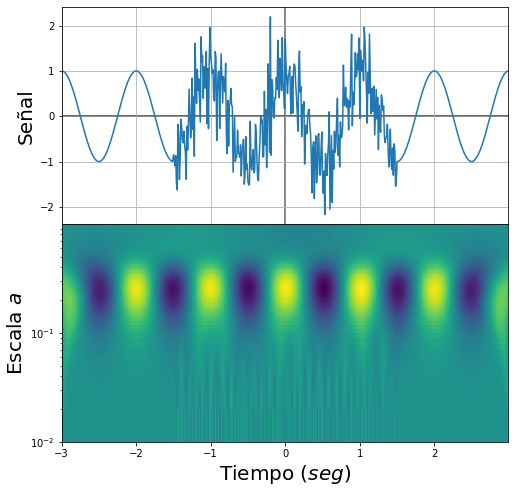

In [ ]:
Fs = 100
Ts = 1/Fs
Te = 1e-2
t_dis = np.arange(-3, 3, Ts)
e = np.zeros(t_dis.shape[0]) 
m = .5*np.random.randn(int(t_dis.shape[0]*0.75))
for i in range(int(t_dis.shape[0]*0.25), m.shape[0]):
    e[i] = m[i]
sig  = np.cos(2 * np.pi * 1 * t_dis) + e
WT = Wavelet_trasform(sig, t_dis, 0.01, [1e-2, 1], 1e-2, False)
WT.grap()

Note que si se aplica la transformada inversa Wavelet sin tener en cuenta los valores de escala en los cuales se resaltan las estructuras del ruido localizado, es posible filtrar la señal original. De hecho, el parámetro $a$ permite controlar el ancho de banda del espectro de magnitud de la función Wavelet madre, que resulta ser un filtro pasa banda. Recuerde que si el parámetro $a$ aumenta, el ancho de banda disminuye. A continuación se aplica la transformada Wavelet inversa a la señal cosenoidal con ruido localizado con el fin de filtrar.

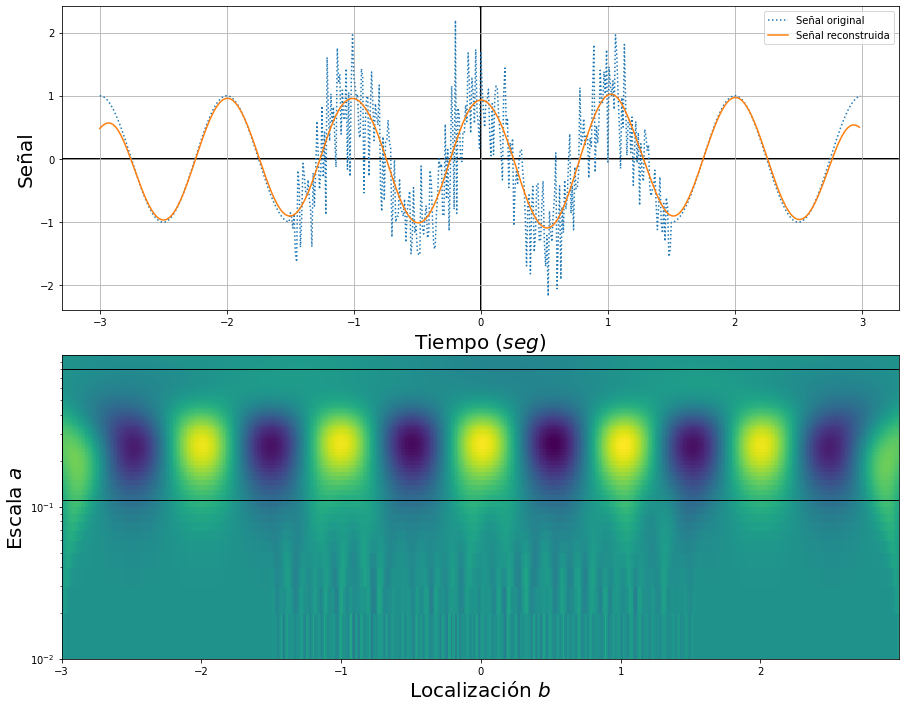

In [ ]:
WT.inverse(.8, .11, 3, -3)

La señal reconstruida es entonces una aproximación de la función cosenoidal sin ruido. No es posible representar la función sin ruido de forma exacta debido a que parte de la energía de esta se encontraba en las componentes de la transformada Wavelet que no se tuvieron en cuenta a la hora de reconstruir la señal. Estas componentes están mezcladas con la parte de la señal que posee ruido.

De forma general, es posible reconstruir una señal o aproximar alguna componente particular de ella a partir de su representación mediante la transformada Wavelet especificando las escalas que se desean incluir (que es equivalente a seleccionar las componentes de frecuencias) e  incluso si se desea, establecer los valores de localización a tener en cuenta.

$$
x(t) = \frac{1}{C_g}~\int_{b_{min}}^{b_{max}} \int_{a_{min}}^{a_{max}} T(a, b)~\psi_{a, b}(t)~\frac{da}{a^2}~db
$$

La siguiente figura muestra la reconstrucción de una señal a partir de su transformada Wavelet inversa en donde se especifican los valores de 
$a_{max}$, $a_{min}$, $b_{max}$, $b_{min}$.


# Ejercicio

Realizar las simulaciones según las combinaciones disponibles y discutir en cada caso

In [ ]:
Fs = 200
Ts = Fs**-1
Te = 1e-2
t_dis = np.arange(-2, 6, Ts)
sig_1 = 7*np.ones(t_dis.shape)
sig_2 = 80*np.sin(2*np.pi*.5*t_dis)
sig_3 = 70*np.sin(2*np.pi*4*t_dis)
sig_4 = 100*np.piecewise(t_dis, [t_dis>=0], [lambda x: np.exp(-x)])
sig_5 = np.piecewise(t_dis, [t_dis>=-1, t_dis>=4], [lambda x: np.random.normal(0, 200, 1399), 0])
def SIGNALS(s1, s2, s3, s4, s5, grap = True):
  sig_T = sig_1*s1 + sig_2*s2 + sig_3*s3 + sig_4*s4 + sig_5*s5
  Te = 1e-2
  scales = np.arange(1e-2, 10, Te)
  coefs = Wavelet_trasform(sig_T, [-2, 6], Ts, [1e-2, 10], Te, False).coefs
  fig = plt.figure(constrained_layout=True, figsize=(15, 10))
  gs = fig.add_gridspec(7, 3)
  ax_sig_1 = fig.add_subplot(gs[0, 0])
  ax_sig_1.set_visible(s1)
  ax_sig_1.plot(t_dis, sig_1)
  ax_sig_1.grid()
  ax_sig_1.set_title('Componente offset')
  ax_sig_1.set_ylabel('Señal')
  ax_sig_1.set_xlabel('Tiempo $(seg)$')
  ax_sig_2 = fig.add_subplot(gs[1, 0])
  ax_sig_2.set_visible(s2)
  ax_sig_2.plot(t_dis, sig_2)
  ax_sig_2.set_title('Componente de baja frecuencia')
  ax_sig_2.grid()
  ax_sig_2.set_ylabel('Señal')
  ax_sig_2.set_xlabel('Tiempo $(seg)$')
  ax_sig_3 = fig.add_subplot(gs[2, 0])
  ax_sig_3.plot(t_dis, sig_3)
  ax_sig_3.set_visible(s3)
  ax_sig_3.set_title('Componente de alta frecuencia')
  ax_sig_3.grid()
  ax_sig_3.set_ylabel('Señal')
  ax_sig_3.set_xlabel('Tiempo $(seg)$')
  ax_sig_4 = fig.add_subplot(gs[3, 0])
  ax_sig_4.plot(t_dis, sig_4)
  ax_sig_4.set_visible(s4)
  ax_sig_4.set_title('Discontinuidad')
  ax_sig_4.grid()
  ax_sig_4.set_ylabel('Señal')
  ax_sig_4.set_xlabel('Tiempo $(seg)$')
  ax_sig_5 = fig.add_subplot(gs[4, 0])
  ax_sig_5.set_visible(s5)
  ax_sig_5.plot(t_dis, sig_5)
  ax_sig_5.set_title('Ruido')
  ax_sig_5.grid()
  ax_sig_5.set_ylabel('Señal')
  ax_sig_5.set_xlabel('Tiempo $(seg)$')
  ax_sig_T = fig.add_subplot(gs[5:, :])
  ax_sig_T.plot(t_dis, sig_T)
  ax_sig_T.set_title('Señal total')
  ax_sig_T.grid()
  ax_sig_T.set_ylabel('Señal')
  ax_sig_T.set_xlabel('Tiempo $(seg)$')
  ax_WT = fig.add_subplot(gs[:5, 1:])
  ax_WT.pcolormesh(t_dis, scales, coefs)
  ax_WT.set_title('Transformada Wavelet')
  ax_WT.set_yscale('log')
  ax_WT.set_ylabel('Escala $a$')
  ax_WT.set_xlabel('Localización $b$')
  if grap == True:
    fig.show()
  else:
    fig.clear()
    return sig_T
w_1 = interactive(SIGNALS, {'manual': True, 'manual_name': 'Cargar'}
                    , s1=ipywidgets.Checkbox(value = False, description = 'Componente offset')
                    , s2=ipywidgets.Checkbox(value = False, description = 'Componente de baja frecuencia')
                    , s3=ipywidgets.Checkbox(value = False, description = 'Componente de alta frecuencia')
                    , s4=ipywidgets.Checkbox(value = False, description = 'Discontinuidad')
                    , s5=ipywidgets.Checkbox(value = False, description = 'Ruido')
                    , grap = ipywidgets.Checkbox(value = True, layout = ipywidgets.Layout(visibility='hidden')))
display(w_1)


interactive(children=(Checkbox(value=False, description='Componente offset'), Checkbox(value=False, descriptio…

In [ ]:
def icwt(amin, amax, bmin, bmax):
  IWT = Wavelet_trasform(SIGNALS(w_1.children[0].value, w_1.children[1].value,
                                 w_1.children[2].value, w_1.children[3].value, w_1.children[4].value, grap =False)
      , t_dis, Ts, [1e-2, 10], Te, False).inverse(amax, amin, bmax, bmin)
  return IWT
w_2 = interactive(icwt, {'manual': True, 'manual_name': 'Cargar'}
                    , amin=ipywidgets.FloatSlider(value=1e-2, min=1e-2, max=10, step=1e-2, description='a min:', continuous_update=False)
                    , amax=ipywidgets.FloatSlider(value=10, min=1e-2, max=10, step=1e-2, description='a max:', continuous_update=False)
                    , bmin=ipywidgets.FloatSlider(value=-2, min=-2, max=6, step=.5, description='b min:', continuous_update=False)
                    , bmax=ipywidgets.FloatSlider(value=6, min=-2, max=6, step=.5, description='b max:', continuous_update=False))
display(w_2)

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='a min:', max=10.0, min=0.0…

Note que a pesar de que la reconstrucción no es perfecta, es posible distinguir las oscilaciones presentes en una señal muy ruidosa y con discontinuidades

La siguiente figura muestra el espectro de magnitud y fase de la transformada de Fourier de la señal en el cual, no es posible distinguir algún tipo de discontinuidad ni localizar el ruido en el tiempo.

<Figure size 1080x720 with 0 Axes>

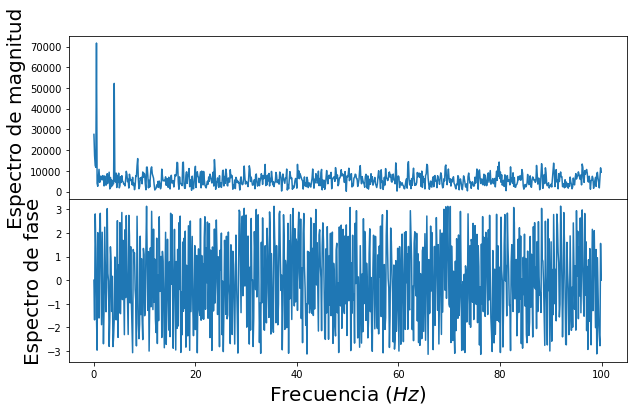

In [ ]:
x_f = ft.rfft(SIGNALS(True, True, True, True, True, False))
freqs = (ft.rfftfreq(len(x_f)*2-1, Ts))
fig, axs = plt.subplots(2, figsize=(10,6), gridspec_kw={'hspace': 0})
axs[0].plot(freqs, np.abs((x_f)))
axs[0].set_ylabel('Espectro de magnitud', fontsize=20)
axs[1].plot(freqs, np.angle((x_f)))
axs[1].set_ylabel('Espectro de fase', fontsize=20)
axs[1].set_xlabel('Frecuencia $(Hz)$', fontsize=20)
fig.show()

Pese a que la forma de las componentes de la señal reconstruidas a partir de la transformada discreta inversa de Fourier coinciden mejor con las originales, presentan un desfase de $90^{o}$. Más adelante se comparan estos resultados con la transformada discreta inverse Wavelet.

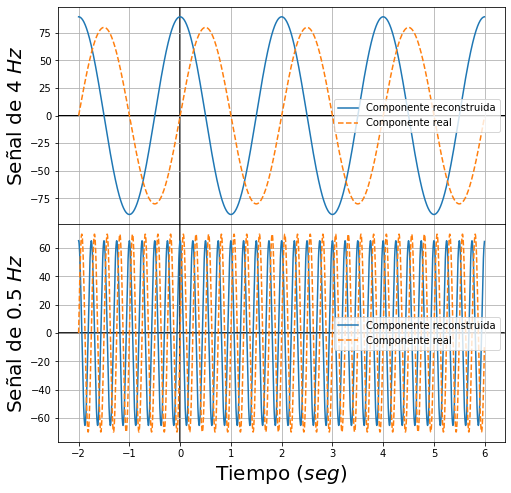

In [ ]:
f_1, f_2 = np.where(np.abs(x_f) == np.sort(np.abs(x_f))[-1]), np.where(np.abs(x_f) == np.sort(np.abs(x_f))[-2])
xf_1, xf_2 = np.zeros(x_f.shape), np.zeros(x_f.shape)
xf_1[f_1], xf_2[f_2] = np.abs(x_f[f_1]), np.abs(x_f[f_2])
xt_1, xt_2 = ft.irfft(xf_1), ft.irfft(xf_2)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8,8))
axs[0].plot(t_dis, xt_1, label = 'Componente reconstruida')
axs[0].plot(t_dis, sig_2, label = 'Componente real', ls='--')
axs[0].grid()
axs[0].arrow(0, axs[0].axis()[2], 0, -axs[0].axis()[2]+axs[0].axis()[3], width=.005, length_includes_head=True, color='k')
axs[0].arrow(axs[0].axis()[0], 0, -axs[0].axis()[0]+axs[0].axis()[1], 0, width=.005, length_includes_head=True, color='k')
axs[0].set_ylabel('Señal de $4~Hz$', fontsize=20)
axs[0].legend(loc = 'best')
axs[1].plot(t_dis, xt_2, label = 'Componente reconstruida')
axs[1].plot(t_dis, sig_3, label = 'Componente real', ls='--')
axs[1].grid()
axs[1].arrow(0, axs[1].axis()[2], 0, -axs[1].axis()[2]+axs[1].axis()[3], width=.005, length_includes_head=True, color='k')
axs[1].arrow(axs[1].axis()[0], 0, -axs[1].axis()[0]+axs[1].axis()[1], 0, width=.005, length_includes_head=True, color='k')
axs[1].set_ylabel('Señal de $0.5~Hz$', fontsize=20)
axs[1].set_xlabel('Tiempo $(seg)$', fontsize=20)
axs[1].legend(loc='best')
fig.show()

# Ejercicio

Según lo estudiado encuentre la transformada wavelet para un par de canales de EEG utilizando dos funciones madre distinta. Luego realice la reconstrucción de las señales en aras de filtrar la información en las bandas $\alpha$ y $\beta$ (8-12 Hz y 12-30 Hz)